# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [3]:
!pip install pandas scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 4.6 MB/s eta 0:00:0000:0100:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.6/229.6 kB 3.6 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.4-cp38-cp38-macosx_11_0_arm64.whl (63 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.5 MB/s eta 0:00:0000:0100:01m
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sticky-notes-clustering 1.124 requires fasttext==0.9.1, which is not installed.
sticky-notes-clustering 1.124 requires tensorflow==2.5.0, which is not installed.
sticky-notes-clustering 1.124 requires diameter-clustering==0.0.1, but you have diameter-clustering 0.1.0 which is incompatible.
sticky-notes-clustering 1.124 requires matplotlib==2.2.2, but you have matplotlib 

## Рекуррентные нейронные сети

Рекуррентные нейронные сети (RNN) предназначены для работы с последовательностями (в том числе текстом). По устройству они похожи на цикл, где каждый шаг связан с предудущими через внешние переменные, в которые записывается нужная информация по каким-то условиям. Так как в рекурентных сетях вычисления происходят последовательно, обучение плохо поддается параллелизации. Простыми словами, рекурректные сети медленные. Но их неэффективность часто компенсируется точностью, поэтому рекурректные сети - это стандартный инструмент при работе с текстами.  

## Классификация текста с помощью RNN

Давайте посмотрим, как в тензорфлоу использовать рекуррентные слои и как их соединять с Embedding и Dense слоями.

## Код с прошлых занятий

In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

Возьмем небольшой кусок датасета [lenta.ru](https://github.com/yutkin/Lenta.Ru-News-Dataset). Попробуем предсказывать тематику текста

In [3]:
data = pd.read_csv('lenta_40k.csv.zip')

In [4]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [103]:
data.topic.unique()

array(['Спорт', 'Мир', 'Интернет и СМИ', 'Россия', 'Наука и техника',
       'Силовые структуры', 'Бывший СССР', 'Культура', 'Экономика',
       'Ценности', 'Из жизни', 'Дом', 'Бизнес', '69-я параллель', 'Крым',
       'Путешествия', 'Культпросвет ', 'Легпром', 'Библиотека'],
      dtype=object)

Предобработка нам тут особо не важна.

In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

В tf есть много встроенны метрик, но нет f1 меры. Можно воспользоваться вот такой функцией, взятой со stackoverflow

In [6]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Как и раньше, создаем словарь, фильтруем, чтобы он был адекватного размера и переводим токены в индексы

In [7]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [8]:
len(vocab)

354611

In [9]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [10]:
len(filtered_vocab)

24091

In [11]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [14]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [15]:
MEAN_LEN = np.median([len(x) for x in X])

In [16]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [17]:
MAX_LEN = int(MEAN_LEN + 30)

In [18]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [19]:
X.shape

(44356, 200)

In [20]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [21]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [22]:
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

Есть несколько разновидностей рекуррентных слоев - RNN (vanila rnn), GRU, LSTM. 

Первый - самый простой рекуррентный слой, где на каждом шаге используется предыдущее состояние и текущий вектор, они складываются и умножаются на матрицу весов с функцией активации, полученный вектор передается на следующий шаг. Проблема с обычными RNN в том, что информация о предыдущих состояних очень быстро затирается и учитывать нелокальные зависимости не получается. 


Можно **схематично** представить Vanilla RNN вот таким циклом в питоне:

In [28]:
# это вектор внутреннего состояния, можно его рассматривать как память 
hidden_state = [0, 0, ...] 

# ванила рнн это цикл по векторам слов в тексте
for token_vector in text_vectors:
    # на каждом шаге вектор текущего слова складывается с вектором памяти и к ним применяется
    # полносвязный слой и функция активации tanh (гиперболический тангенс)
    # tanh переводит числа в интервал от -1 до 1
    hidden_state = tanh(W(hidden_state + token_vector))




LSTM и GRU частично решают эту проблему добавлением дополнительных матриц весов и активаций, которые будут отвечать за то, чтобы нужная информация сохранялась на протяжении всей последовательности, а ненужная удалялась.

Схематично LSTM можно представить вот так:

In [ ]:
# в LSTM две переменные для памяти (отсюда и название Long-short memory network, 
#                                одна переменная для короткой памяти другая для долгой)
# cell_state используется только внутри ячейки (это long memory)
cell_state = [0, 0, ...]
# а hidden_state также передается наружу (его можно использовать для классификации)
hidden_state = [0, 0, ...]

# цикл точно также идет по векторам слов в тексте
for token_vector in text_vectors:
    # запоминание/забывание в LSTM реализовано с помощью механизма, который называется gate
    # есть три гейта - гейт забывания (forget_gate), входной гейт (input gate), и выходной гейт (output_gate)
    # гейт - это полносвязный слой с функцией активации сигмоида (она выдает числа от 0 до 1)
    # по сути это веса которые пременяются к hidden_state, cell_state
    # например, результат forget_gate может выглядеть как [0.02, 0.01, 0.99]
    # он будет означать что нужно почти полностью забыть то что хранится в 1 и 2 размерности, но оставить то что в 3
    forget_gate = sigmoid(W_forget(hidden_state + token_vector))
    input_gate = sigmoid(W_input(hidden_state + token_vector))
    output_gate = sigmoid(W_output(hidden_state + token_vector))
    
    # гейты это веса, а сами значения для векторов cell_state и hidden_state получаются через tanh
    # обновление cell_state, hidden_state происходит следующим образом:
    # 1. forget_gate применяется к cell_state. Это поточечное умножение двух векторов 
    # (в питоне * означает обычное умножение, правильно было бы написать pointwise_multiply
    #  но т.к. это просто схема я написал просто *) 
    # Этот шаг отвечает за удаление из долгой памяти
    # Т.е гейт смотрит на текущую кратковременную память и текущее слова и решает, что можно удалить из долгой памяти
    cell_state_forgotten = forget_gate * cell_state
    
    # 2. в cell_state сохраняется новая информация
    # Чтобы что-то сохранить в долгую память нужно скомбинировать текущее слово и короткую память
    # и привести это к формату в котором хранится долговременная память 
    # Комбинирование - это просто сложение hidden_state и token_vector
    # А приведение к нужному формату это полносвязный слой и все тот же tanh
    candidate = tanh(W_candidate(hidden_state + token_vector))
    # важность новой информации определяет input_gate
    input = candidate * input_gate
    # итоговый cell_state получается удалением ненужного и добавлением актуального
    cell_state = cell_state_forgotten + input
    # таким образом на каждом шаге гейты забывания и запоминания решают что и в какой пропорции помнить, а что забыть
    # обратите внимание, что это не статичные веса (10 % забываем,  20% запоминаем), 
    # каждый раз веса получаются разные в зависимости от текущего слова и короткой памяти
    
    # 3. обновляется короткая память (hidden_state)
    # hidden_state вычисляется из обновленного cell_state с помощью output_gate
    # Можно интепретировать это как-то так:
    # модель выбирает из памяти только наиболее релевантную текущему слову информацию
    # Если текущее слово глагол, то в hidden_state может записаться информация о самом глаголе (значение, время, лицо)
    # а также информация о связанных с ним словах (местоимении, именной группе, отрицательной частите)
    hidden_state = tanh(cell_state) * output_gate
    
    

А GRU вот так:

In [ ]:
# в GRU только одна переменная для памяти
hidden_state = [0, 0, ...]

for token_vector in text_vectors:
    # механизм запоминания/забывания тоже реализован через гейты
    # В GRU 2 гейта - reset (забывание) и update (запоминание)
    # расчитываются они применением полносвязного слоя к текущему слову и памяти с сигмоидой
    reset = sigmoid(W_reset(token_vector + hidden_state))
    update = sigmoid(W_update(token_vector + hidden_state))
    
    # Обновление hidden_state устроено следующим образом:
    # 1. Из памяти выбирается только нужная информация с помощью reset gate
    # На основе актуальной памяти и текущего вектора считается новый потенциальный вектор hidden_state
    # Это делается полносвязным слоем и tanh
    candidate_hidden_state = tanh(W_candidate((hidden_state * reset) + token_vector)) 
    
    # 2. update gate решает в какой пропорции совместить память и потенциальный hidden_state
    # тут два раза используется update но во втором случае он вычитается из единицы
    # вычитание из единицы отзеркаливает update (если update [0.2, 0.45], то 1-update = [0.8, 0.55])
    # Если значения в update маленькие, то в 1-update будут большие, т.е. 
    # модель возьмет почти все из памяти и почти ничего из потенциального вектора (и наоборот)
    hidden_state = (update * candidate_hidden_state) + ( (1-update) * hidden_state )
    

На картинке все три типа можно изобразить вот так:

In [135]:
# lstm cell
Image(url="https://habrastorage.org/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png",
     width=1000, height=1000)

На практике выбор стоит между LSTM и GRU. По описанию и графику можно заметить, что в LSTM 4 матрицы с весами, а в GRU 3. Таким образом, GRU - немного проще (а значит быстрее) LSTM. Но это не значит, что LSTM лучше работает (сложное не значит хорошее). Как и с другими алгоритмами машинного обучения все зависит от задачи. Лучше пробовать и то и другое (или даже совмещать).

Ссылки, чтобы разобраться подробнее:  
    http://karpathy.github.io/2015/05/21/rnn-effectiveness/  
    https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21  
    https://colah.github.io/posts/2015-08-Understanding-LSTMs/  
    
    
    
    

Использовать RNN слой в tf проще, чем понять, как он устроен. Нужно просто поставить его после другого слоя, который возвращает последовательность (например, после Embedding слоя).

При return_sequences=False в следующий слой будет передаваться только последнее состояние - 1 вектор, т.е. не нужно конкатенировать

In [35]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )


# rnn = tf.keras.layers.SimpleRNN(128, return_sequences=False)(embeddings)
rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)
# rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, 
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


Схема задачи, чтобы было понятнее:

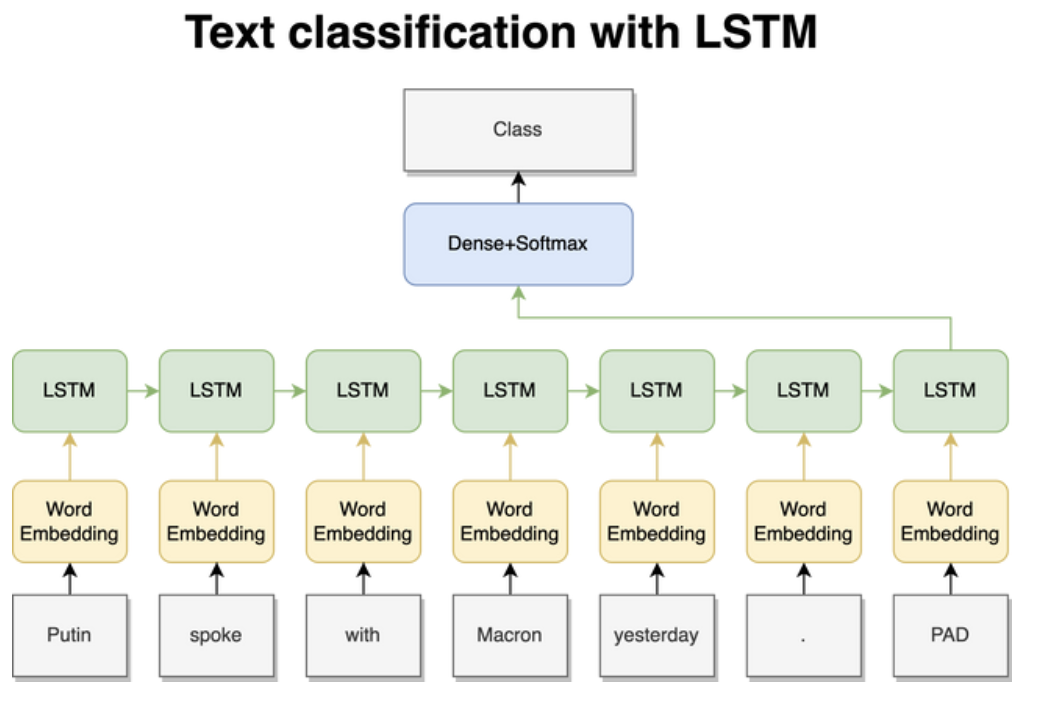

In [36]:
# вместо lstm может быть gru
Image(filename='image (7).png',
     width=500, height=500)


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 lstm (LSTM)                 (None, 128)               81408     
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                                 
Total params: 806,649
Trainable params: 806,649
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20


2023-02-08 14:03:41.356001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:03:41.521241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:03:42.456524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 2.5912 - f1: 0.0000e+00 - rec@prec: 0.0000e+00

2023-02-08 14:04:00.876795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:04:00.952347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 21s 436ms/step - loss: 2.5912 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3298 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 16s 363ms/step - loss: 2.3178 - f1: 0.0000e+00 - rec@prec: 7.1195e-05 - val_loss: 2.3072 - val_f1: 0.0000e+00 - val_rec@prec: 0.0014
Epoch 3/20
43/43 [==============================] - 17s 397ms/step - loss: 2.2667 - f1: 0.0000e+00 - rec@prec: 1.1866e-04 - val_loss: 2.1539 - val_f1: 0.0000e+00 - val_rec@prec: 0.0104
Epoch 4/20
43/43 [==============================] - 18s 423ms/step - loss: 2.1928 - f1: 0.0062 - rec@prec: 2.3732e-05 - val_loss: 2.1477 - val_f1: 0.0025 - val_rec@prec: 4.5086e-04
Epoch 5/20
43/43 [==============================] - 21s 480ms/step - loss: 1.9034 - f1: 0.1338 - rec@prec: 0.0458 - val_loss: 2.2186 - val_f1: 0.2049 - val_rec@prec: 0.0325
Epoch 6/20
43/43 [==============================] - 18s 415ms/step - loss: 1.8417 - f1: 0.2304 - r

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


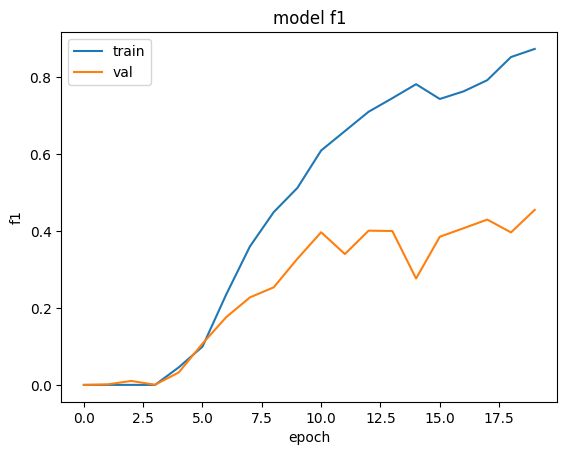

In [40]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Рекуррентные слои можно накладывать друг на друга. Нужно только указать параметр return_sequences=True, т.к. слой ожидает на вход последовательность. Длина последовательности не изменяется, поэтому можно совмещать сколько угодно слоев. Это называется stacked LSTM/GRU.

Основной параметр в LSTM/GRU слое - units. Чем он больше, тем больше весов будет в модели. Он будет соответствовать размеру вектора состояния (hidden_state). Он может быть любой даже при накладывании слоев друг на друга (они могут быть одинаковые как тут, первый может быть больше, второй может быть больше).

In [49]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.GRU(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [50]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm_4 (LSTM)               (None, 200, 128)          81408     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 19)                1235      
                                                                 
Total params: 912,761
Trainable params: 912,761
Non-trainab

In [51]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15


2023-02-08 14:35:44.167153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:35:44.403324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:35:44.733568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:35:45.396863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:35:46.095878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - ETA: 0s - loss: 2.3545 - f1: 0.0018 - rec@prec: 0.0000e+00

2023-02-08 14:36:19.876533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:36:19.982450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:36:20.270586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - 40s 170ms/step - loss: 2.3545 - f1: 0.0018 - rec@prec: 0.0000e+00 - val_loss: 2.2624 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
211/211 [==============================] - 32s 150ms/step - loss: 2.2950 - f1: 0.0014 - rec@prec: 0.0000e+00 - val_loss: 2.3192 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/15
211/211 [==============================] - 80s 381ms/step - loss: 2.1127 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.0043 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/15
211/211 [==============================] - 77s 364ms/step - loss: 1.9158 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 1.9515 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/15
211/211 [==============================] - 32s 153ms/step - loss: 1.8166 - f1: 0.0012 - rec@prec: 1.1866e-04 - val_loss: 2.0403 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/15
211/211 [==============================] - 32s 150ms/step

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


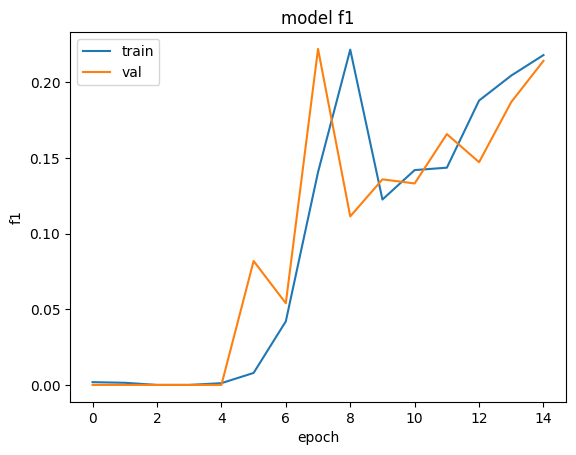

In [53]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Рекурретную сеть можно применить в прямом и обратном порядке и объединить состояния в одно (половина вектора будет про инфу до, половина про инфу после). Это назвается Bidirectional и делается в tf очень просто. 

In [54]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


Схема задачи, чтобы было понятнее.

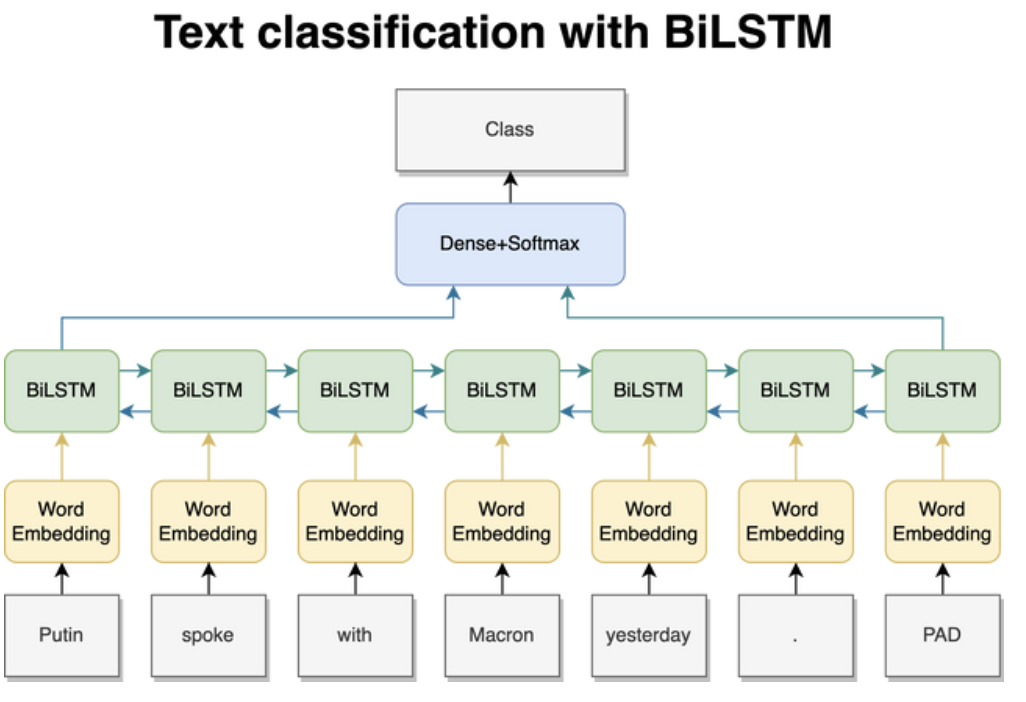

In [55]:
Image(filename='image (8).png',
     width=500, height=500)

In [56]:
model.summary()
# обратите внимание на размер output в biderectional
# он равен units * 2

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 200, 100)          2409300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 19)                4883      
                                                                 
Total params: 2,648,679
Trainable params: 2,648,679
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
         epochs=20)

Epoch 1/20


2023-02-08 14:46:01.734773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:46:01.970796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:46:01.988141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:46:02.654900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:46:02.670865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - ETA: 0s - loss: 2.2092 - f1: 0.0251 - rec@prec: 2.3732e-05

2023-02-08 14:46:45.075121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:46:45.196670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:46:45.205023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - 47s 207ms/step - loss: 2.2092 - f1: 0.0251 - rec@prec: 2.3732e-05 - val_loss: 1.7353 - val_f1: 0.1728 - val_rec@prec: 0.1037
Epoch 2/20
211/211 [==============================] - 42s 200ms/step - loss: 1.6257 - f1: 0.3009 - rec@prec: 0.1268 - val_loss: 1.6880 - val_f1: 0.2924 - val_rec@prec: 0.0843
Epoch 3/20
211/211 [==============================] - 41s 194ms/step - loss: 1.3759 - f1: 0.4914 - rec@prec: 0.3118 - val_loss: 1.4174 - val_f1: 0.5303 - val_rec@prec: 0.2701
Epoch 4/20
211/211 [==============================] - 41s 192ms/step - loss: 1.0937 - f1: 0.6413 - rec@prec: 0.5488 - val_loss: 1.3809 - val_f1: 0.5775 - val_rec@prec: 0.3629
Epoch 5/20
211/211 [==============================] - 41s 193ms/step - loss: 0.9345 - f1: 0.7132 - rec@prec: 0.6668 - val_loss: 1.3474 - val_f1: 0.6117 - val_rec@prec: 0.4098
Epoch 6/20
211/211 [==============================] - 40s 189ms/step - loss: 0.9117 - f1: 0.7203 - rec@prec: 0.6740 - val_loss: 1.43

KeyboardInterrupt: 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


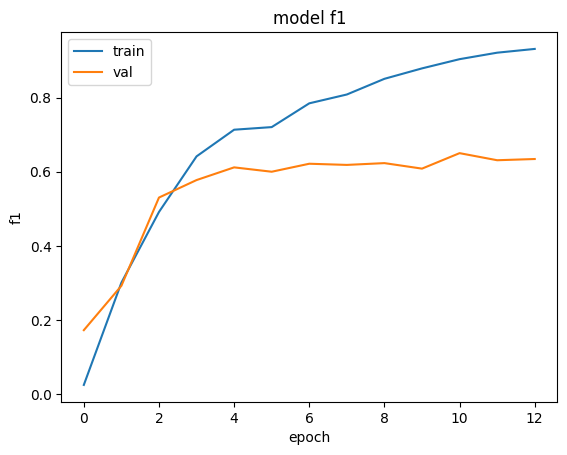

In [58]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NB: когда мы оборачиваем LSTM в Bidirectional, то этот слой применяется и напрямую и обратно. Кажется, что логичнее иметь один слой для прямого прогона и один для обратного.
В Bidirectional можно также указать отдельный backward_layer, чтобы использовался новый слой.

In [108]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

# 1 слой на 2 прогона вручную
# lstm = tf.keras.layers.LSTM(128, return_sequences=False)
# lstm_forward = lstm(embeddings)
# lstm_backward = lstm(embeddings[::-1])

# 2 слоя вручную
lstm_forward =  tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)
lstm_backward =  tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True)(embeddings)

hidden = tf.keras.layers.concatenate([lstm_forward, lstm_backward])

# 2 слоя через Bidirectional
# hidden = tf.keras.layers.Bidirectional(
#                                        tf.keras.layers.LSTM(128, return_sequences=False),
#                         backward_layer=tf.keras.layers.LSTM(128, return_sequences=False, 
#                                                             go_backwards=True))(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [109]:
model.summary()
# обратите внимание на размер output в biderectional
# он равен units * 2

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 54)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 54, 100)      3601700     ['input_11[0][0]']               
                                                                                                  
 lstm_11 (LSTM)                 (None, 128)          117248      ['embedding_10[0][0]']           
                                                                                                  
 lstm_12 (LSTM)                 (None, 128)          117248      ['embedding_10[0][0]']           
                                                                                           

In [61]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
         epochs=10)

Epoch 1/10


2023-02-08 14:55:39.922753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:55:40.329605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:55:40.340415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:55:41.228043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:55:41.243037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - ETA: 0s - loss: 2.1624 - f1: 0.0134 - rec@prec: 1.1866e-04

2023-02-08 14:56:31.820715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:56:31.962997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:56:31.984077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - 56s 247ms/step - loss: 2.1624 - f1: 0.0134 - rec@prec: 1.1866e-04 - val_loss: 1.9003 - val_f1: 0.0730 - val_rec@prec: 0.0654
Epoch 2/10
211/211 [==============================] - 46s 218ms/step - loss: 1.6782 - f1: 0.2219 - rec@prec: 0.1038 - val_loss: 1.7796 - val_f1: 0.2734 - val_rec@prec: 0.1506
Epoch 3/10
211/211 [==============================] - 46s 219ms/step - loss: 1.4556 - f1: 0.4397 - rec@prec: 0.2027 - val_loss: 1.5384 - val_f1: 0.4130 - val_rec@prec: 0.2408
Epoch 4/10
211/211 [==============================] - 45s 215ms/step - loss: 1.2103 - f1: 0.5949 - rec@prec: 0.4487 - val_loss: 1.5127 - val_f1: 0.5365 - val_rec@prec: 0.0857
Epoch 5/10
211/211 [==============================] - 46s 216ms/step - loss: 1.0593 - f1: 0.6695 - rec@prec: 0.5816 - val_loss: 1.3573 - val_f1: 0.5289 - val_rec@prec: 0.2719
Epoch 6/10
211/211 [==============================] - 46s 218ms/step - loss: 0.9084 - f1: 0.7219 - rec@prec: 0.6756 - val_loss: 1.24

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


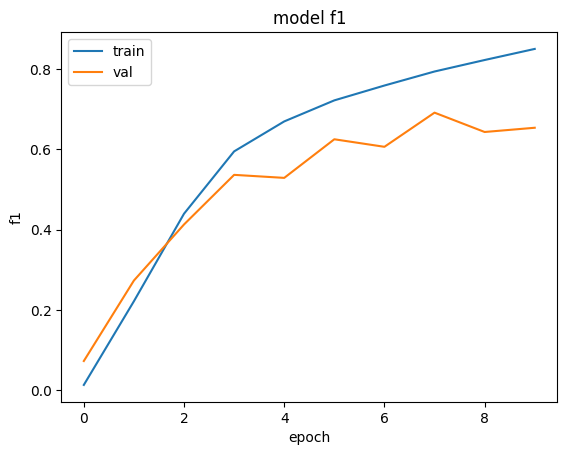

In [62]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Sequence labelling

На выходе из рекурректной сети получается по вектору на каждый элемент последовательности. Мы можем использовать только последний, если нам нужно просто классифицировать весь текст (на последнем состоянии по идее должна была накопиться информация о всей последовательности).

Кроме этого, мы можем классифицировать каждый элемент последовательности. Это называется sequence labelling (разметка последовательности). Под этот паттерн попадает предсказание части речи, определение именованных сущностей, определение опечаток и другие задачи, где длина обоих последовательностей совпадает.

Давайте попробуем выделять именованные сущности.

Данные возьмем из бибиотеки datasets (часть huggingface)

In [63]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 7.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)


In [64]:
from datasets import load_dataset

В этой библиотеке несколько датасетов для именованных сущностей. Мы возьмем датасет, собранный по википедии. Он мультиязычный, но для семинара мы возьмем только русскую часть.

In [65]:
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Exception ignored in: <function tqdm.__del__ at 0x3d0c8c550>
Traceback (most recent call last):
  File "/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/tqdm/notebook.py", line 293, in close
    self.disp(close=True, check_delay=False)
  File "/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/tqdm/notebook.py", line 192, in display
    self.container.close()
  File "/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/ipywidgets/widgets/widget.py", line 500, in close
    self.comm.close()
  File "/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/comm/base_comm.py", line 109, in close
    get_comm_manager().unregister_comm(self)
NameError: name 'get_comm_manager' is not defined
Exception ignored in: <function tqdm.__del__ at 0x3d0c8c550>
Traceback (most recent call last):
  File "/Users/mnefedov/miniforge3/envs

Dataset wikiann downloaded and prepared to /Users/mnefedov/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Датасет уже заранее разбит на трейн, валидацию и тест.

In [66]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

Пример данных

In [67]:
dataset['train']['tokens'][0], dataset['train']['ner_tags'][0]

(['Илизаров', ',', 'Гавриил', 'Абрамович'], [1, 2, 2, 2])

Индексы в разметке соответствуют вот таким классам:

In [68]:
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',  'B-LOC', 'I-LOC']

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

Что они значат?

In [69]:
Image(url="https://editor.analyticsvidhya.com/uploads/19617Intro%20image.jpg",
     width=700, height=600)

**PER, ORG, LOC** - это типы именованных сущностей, Person, Organization и Location. Это стандартные типы сущностей, которые чаще всего приходится выделять. Оценочные датасеты обычно размечены этими типами. Другие популярные сущности - номера телефонов, числа, имейлы, дата, время, но их обычно определяют правилами (регулярками например).

**I, B** - эта часть тэга показывает в какой части именованной сущности находится токен. **B - beggining** (начало), **I - inside** (внутри, т.е. после начала).

**O** - это отрицательный класс (outside или other), т.е. несущность.

Такую разметку назвают IOB, она помогает точнее определять сущности и различать рядом стоящие сущности одного типа. Есть и другие типы (например, BILOU - L означает last, последний токен в сущности, а U - unit, сущность из 1 токена). 

Именованной сущностью в принципе можно считать любую последовательность токенов, которую нужно выделить из текста. В биоинформатике, например, сущностями считаются белки, гены, препараты, заболевания, а при разборе научных статей можно выделять цитаты, ключевые метрики, методы (используемые алгоритмы и модели). 

Для того, чтобы извлекать специфичные типы сущностей вам скорее всего придется либо а) самому размечать данные, либо б) создавать словари, правила и грамматики. А скорее всего и то, и другое. Сущности, размеченные моделью обычно еще нужно привести к стандартному виду и делается это в большинстве случаев маппингом на словарь стандартных форм (например, Вышка, ВШЭ, вше, НИУВШЭ, Высшая школа экономики -> НИУ ВШЭ). Маппинг можно делать с помощью простого словаря или с помощью какой-нибудь функции близости (например, расстояния редактирования).

С помощью правил также можно размечать данные и обучать на этом более сложные модели (в надежде, что сложные модели запомнят разметку и дополнительно научатся обобщать). Такой подход называется weak labelling/weak supervision. Для этого есть такие библиотеки: [Snorkel](https://www.snorkel.org/) , [Rubrix](https://github.com/recognai/rubrix)

Для создания грамматик на русском языке можно использовать [Tomita Parser](https://yandex.ru/dev/tomita/), [Yargy](https://github.com/natasha/yargy). Томита быстрее, но сложнее в использовании (внутри там майстем). Yargy написан на питоне и его проще освоить, внутри там пайморфи. В тетрадке NER_rule_based.ipynb (лежит в этой же папке) есть пример написания грамматик на Yargy. 

Давайте посмотрим, как обучать модели, когда разметка уже есть

In [111]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [112]:
# тут словарь не очень большой и тут нужно предсказывать тэги для всех слов
# поэтому не будем фильтровать словарь
len(vocab)

36015

In [113]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [114]:
id2word = {i:word for word, i in word2id.items()}

In [115]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [116]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [117]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

Теги уже переведены в индексы, но обратный маппинг мы тоже сделаем, чтобы дальше удобнее было проверять работу модели. 
Длина последовательностей тегов должна совпадать с длиной последовательностей токенов, поэтому тут тоже нужно сделать паддинг, но в этом случае мы не можем паддить нулями, т.к. ноль у нас уже забронирован тэгом O. Добавим дополнительный тэг пад и будем использовать его индекс при паддинге (value=7)

In [118]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [119]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

Схема задачи, чтобы было понятнее, что мы предсказываем

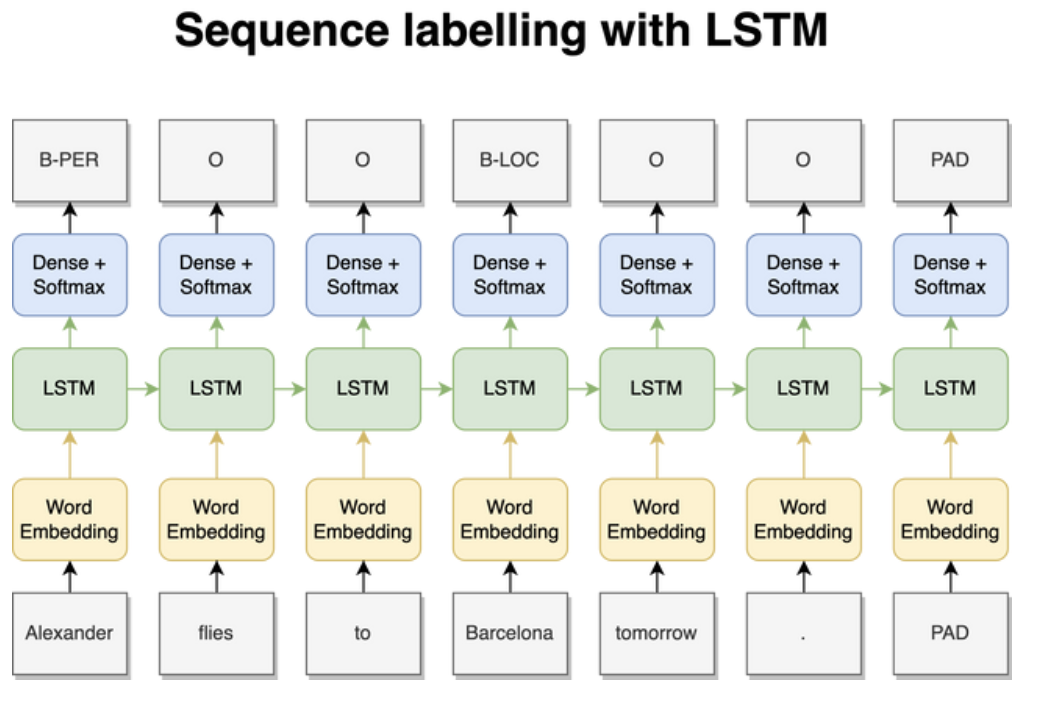

In [120]:
Image(filename='image (9).png',
     width=500, height=500)

In [121]:
X.shape, X_test.shape

((20000, 54), (10000, 54))

In [122]:
y.shape, y_test.shape

((20000, 54), (10000, 54))

In [123]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])


In [124]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5


2023-02-08 18:19:27.818218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:19:28.112748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:19:28.147084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:19:28.923691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:19:28.942078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.9220

2023-02-08 18:19:49.653518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:19:49.792299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:19:49.799813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 27s 147ms/step - loss: 0.3191 - accuracy: 0.9220 - val_loss: 0.1756 - val_accuracy: 0.9437
Epoch 2/5
157/157 [==============================] - 17s 110ms/step - loss: 0.1287 - accuracy: 0.9594 - val_loss: 0.0948 - val_accuracy: 0.9705
Epoch 3/5
157/157 [==============================] - 17s 107ms/step - loss: 0.0618 - accuracy: 0.9810 - val_loss: 0.0623 - val_accuracy: 0.9807
Epoch 4/5
157/157 [==============================] - 17s 108ms/step - loss: 0.0294 - accuracy: 0.9919 - val_loss: 0.0567 - val_accuracy: 0.9824
Epoch 5/5
157/157 [==============================] - 17s 106ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.0543 - val_accuracy: 0.9840


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


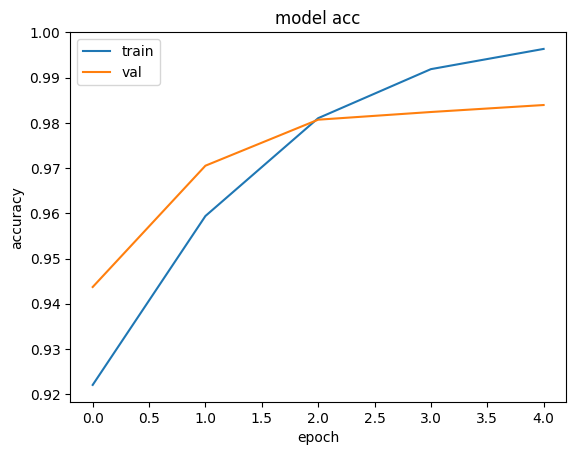

In [125]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Оценивать предсказания последовательностей нужно отдельно. Лучше конечно еще оценивать правильность всей последовательности, но пока сделаем только поэлементную оценку.

In [126]:
from sklearn.metrics import classification_report

In [127]:
pred = model.predict(X_test).argmax(2)

2023-02-08 18:21:00.598754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:21:00.703974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:21:00.717344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 7s 19ms/step


In [128]:
pred

array([[0, 0, 3, ..., 7, 7, 7],
       [0, 0, 5, ..., 7, 7, 7],
       [0, 0, 0, ..., 7, 7, 7],
       ...,
       [1, 2, 0, ..., 7, 7, 7],
       [3, 0, 3, ..., 7, 7, 7],
       [0, 0, 0, ..., 7, 7, 7]])

In [129]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.92      0.96      0.94     40480
       B-PER       0.90      0.81      0.85      3542
       I-PER       0.92      0.86      0.89      7544
       B-ORG       0.66      0.72      0.69      4074
       I-ORG       0.81      0.74      0.77      8008
       B-LOC       0.74      0.77      0.76      4560
       I-LOC       0.84      0.69      0.76      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.85      0.82      0.83    540000
weighted avg       0.98      0.98      0.98    540000



# Предсказание/Inference

После оценки часто хочется посмотреть как будет работать модель на каких-то отдельных примерах. Для этого нужно воспрозвести весь пайплайн и прогонять через него нужный текст.

In [133]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [131]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 193ms/step


[('Алексей', 'B-PER'),
 ('сказал', 'I-PER'),
 ('Светлане', 'I-PER'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('она', 'O'),
 ('собиралась', 'O'),
 ('на', 'O'),
 ('поезд', 'O'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [132]:
label_seq('Я поступил в ВШЭ в Питер', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 47ms/step


[('Я', 'O'),
 ('поступил', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'O'),
 ('в', 'O'),
 ('Питер', 'PAD')]

In [92]:
label_seq('Виктор, Семен, Петр, Арагорн', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 28ms/step


[('Виктор', 'B-PER'),
 (',', 'I-PER'),
 ('Семен', 'B-PER'),
 (',', 'I-PER'),
 ('Петр', 'B-PER'),
 (',', 'I-PER'),
 ('Арагорн', 'I-PER')]